## Kaggle Scores
#### Top Scores 
+ XGBOOSTING Score : ** 1885869.33899 ** RMSE  with  XGBOOSTING regressor 09/09/2019
+ RandomForestScore :** 1769240.65800 ** RMSE with RandomForest regressor 10/09/2019

## Update Notes 
#### 9/11/2019 
+ Removing Outliers reduced the Training error to 0.17, yet increased the kaggle score to 1.8e6, which probably means that the number of resutrants making more than 1e7 is more frequently showing up in the test dataset, on contrary to their occurance in the training datase 

+ Column City seems to have slight effect on Kaggle RMSE

+ fixed some Keras code error, Keras makes INF predictions ..... HOLLY MOLLY

===============================================================================

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/restaurant-revenue-prediction/test.csv
/kaggle/input/restaurant-revenue-prediction/train.csv
/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv
/kaggle/input/restaurant-revenue-prediction/leaderboard.csv


## 1 - Data Loading and Essential exploration

In [2]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#load data
train = pd.read_csv('/kaggle/input/restaurant-revenue-prediction/train.csv')
test = pd.read_csv('/kaggle/input/restaurant-revenue-prediction/test.csv')

In [4]:
train.columns
#Drop sequences 
#train = train.drop('Id', axis=1)
#test = test.drop('Id', axis=1)

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue'],
      dtype='object')

In [5]:
print("Train :",train.shape)
print("Test:",test.shape)

Train : (137, 43)
Test: (100000, 42)


In [6]:
train['Open Date'] = pd.to_datetime(train['Open Date'])
test['Open Date'] = pd.to_datetime(test['Open Date'])

In [7]:
# get column with null values  
train.columns[train.isna().any()].tolist()

[]

In [8]:
test.columns[test.isna().any()].tolist()

[]

As can be seen in the above text, there is no null values in any of the columns which is good, yet we have to explore the relation between the predictors and predicted through EDA 

In [9]:
#Seperate categorical from numberical variables for analysis 
numerical_features = train.select_dtypes([np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude = [np.number,np.datetime64]).columns.tolist()

In [10]:
categorical_features

['City', 'City Group', 'Type']

In [11]:
train[numerical_features].head()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,4,5.0,4.0,4.0,2,2,5,4,5,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,4,5.0,4.0,4.0,1,2,5,5,5,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,2,4.0,2.0,5.0,2,3,5,5,5,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,6,4.5,6.0,6.0,4,4,10,8,10,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,3,4.0,3.0,4.0,2,2,5,5,5,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [12]:
train[categorical_features].head()

,City,City Group,Type
0,İstanbul,Big Cities,IL
1,Ankara,Big Cities,FC
2,Diyarbakır,Other,IL
3,Tokat,Other,IL
4,Gaziantep,Other,IL


## 2 - Data Exploration
In this phase we are going to explore the features and their relations 

## Questions to be answered 

+ Which is the best city to Open a resutrant ? 

+ What is the best time in year to open a resutrant in that city ? 

+ What is the best type of resturant to be opened ? 



## Data Columns
+   #### Id * :  Restaurant id. *
+   #### Open Date *  : opening date for a restaurant * 
+   #### City : *  City that the restaurant is in. Note that there are unicode in the names.  * 
+   #### City Group:  * Type of the city. Big cities, or Other.  * 
+   #### Type: Type of the restaurant. FC: *  Food Court, IL: Inline, DT: Drive Thru, MB: Mobile * 
+   #### P1, P2 - P37: *  There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators. * 
+   #### Revenue: *  The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values.  * 

In [13]:
train.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


## Analyzing Numerical Variables


Check the target column distribution ['revenue']

count    1.370000e+02
mean     4.453533e+06
std      2.576072e+06
min      1.149870e+06
25%      2.999068e+06
50%      3.939804e+06
75%      5.166635e+06
max      1.969694e+07
Name: revenue, dtype: float64


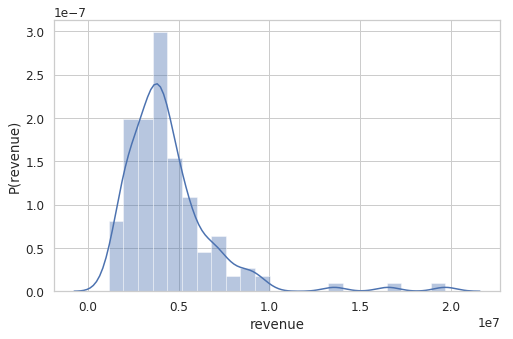

In [14]:
print(train['revenue'].describe())
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    train['revenue'], norm_hist=False, kde=True
).set(xlabel='revenue', ylabel='P(revenue)');

 + As the distribution shows that the data is not mostly left scewed as obvious that the data values are almost ranges between 1.149870e+06 and 1e+07, while the values larger than this number can be problimatic ( anamonlies or outlayer and has to be studied carefully ) 

In [15]:
train[train['revenue'] > 10000000 ]

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
16,16,2000-01-07,İstanbul,Big Cities,FC,3,5.0,4.0,4.0,2,...,2.0,0,0,0,0,0,0,0,0,19696939.0
75,75,2005-10-15,İstanbul,Big Cities,FC,5,5.0,4.0,5.0,1,...,0.0,0,0,0,0,0,0,0,0,16549064.0
99,99,1999-12-18,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,1.0,5,5,4,2,5,5,5,3,13575224.0


In [16]:
# Drop outlayers
train = train[train['revenue'] < 10000000 ]
train.reset_index(drop=True).head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [17]:
train.shape

(134, 43)

+ with a single look in the eye, it is clear that these three resturants have made a significant renvenue despite the fact that they opened in the years 2000 and 2005, unlike other resturants. there has to be some reasons behind this that has to be studied carefully

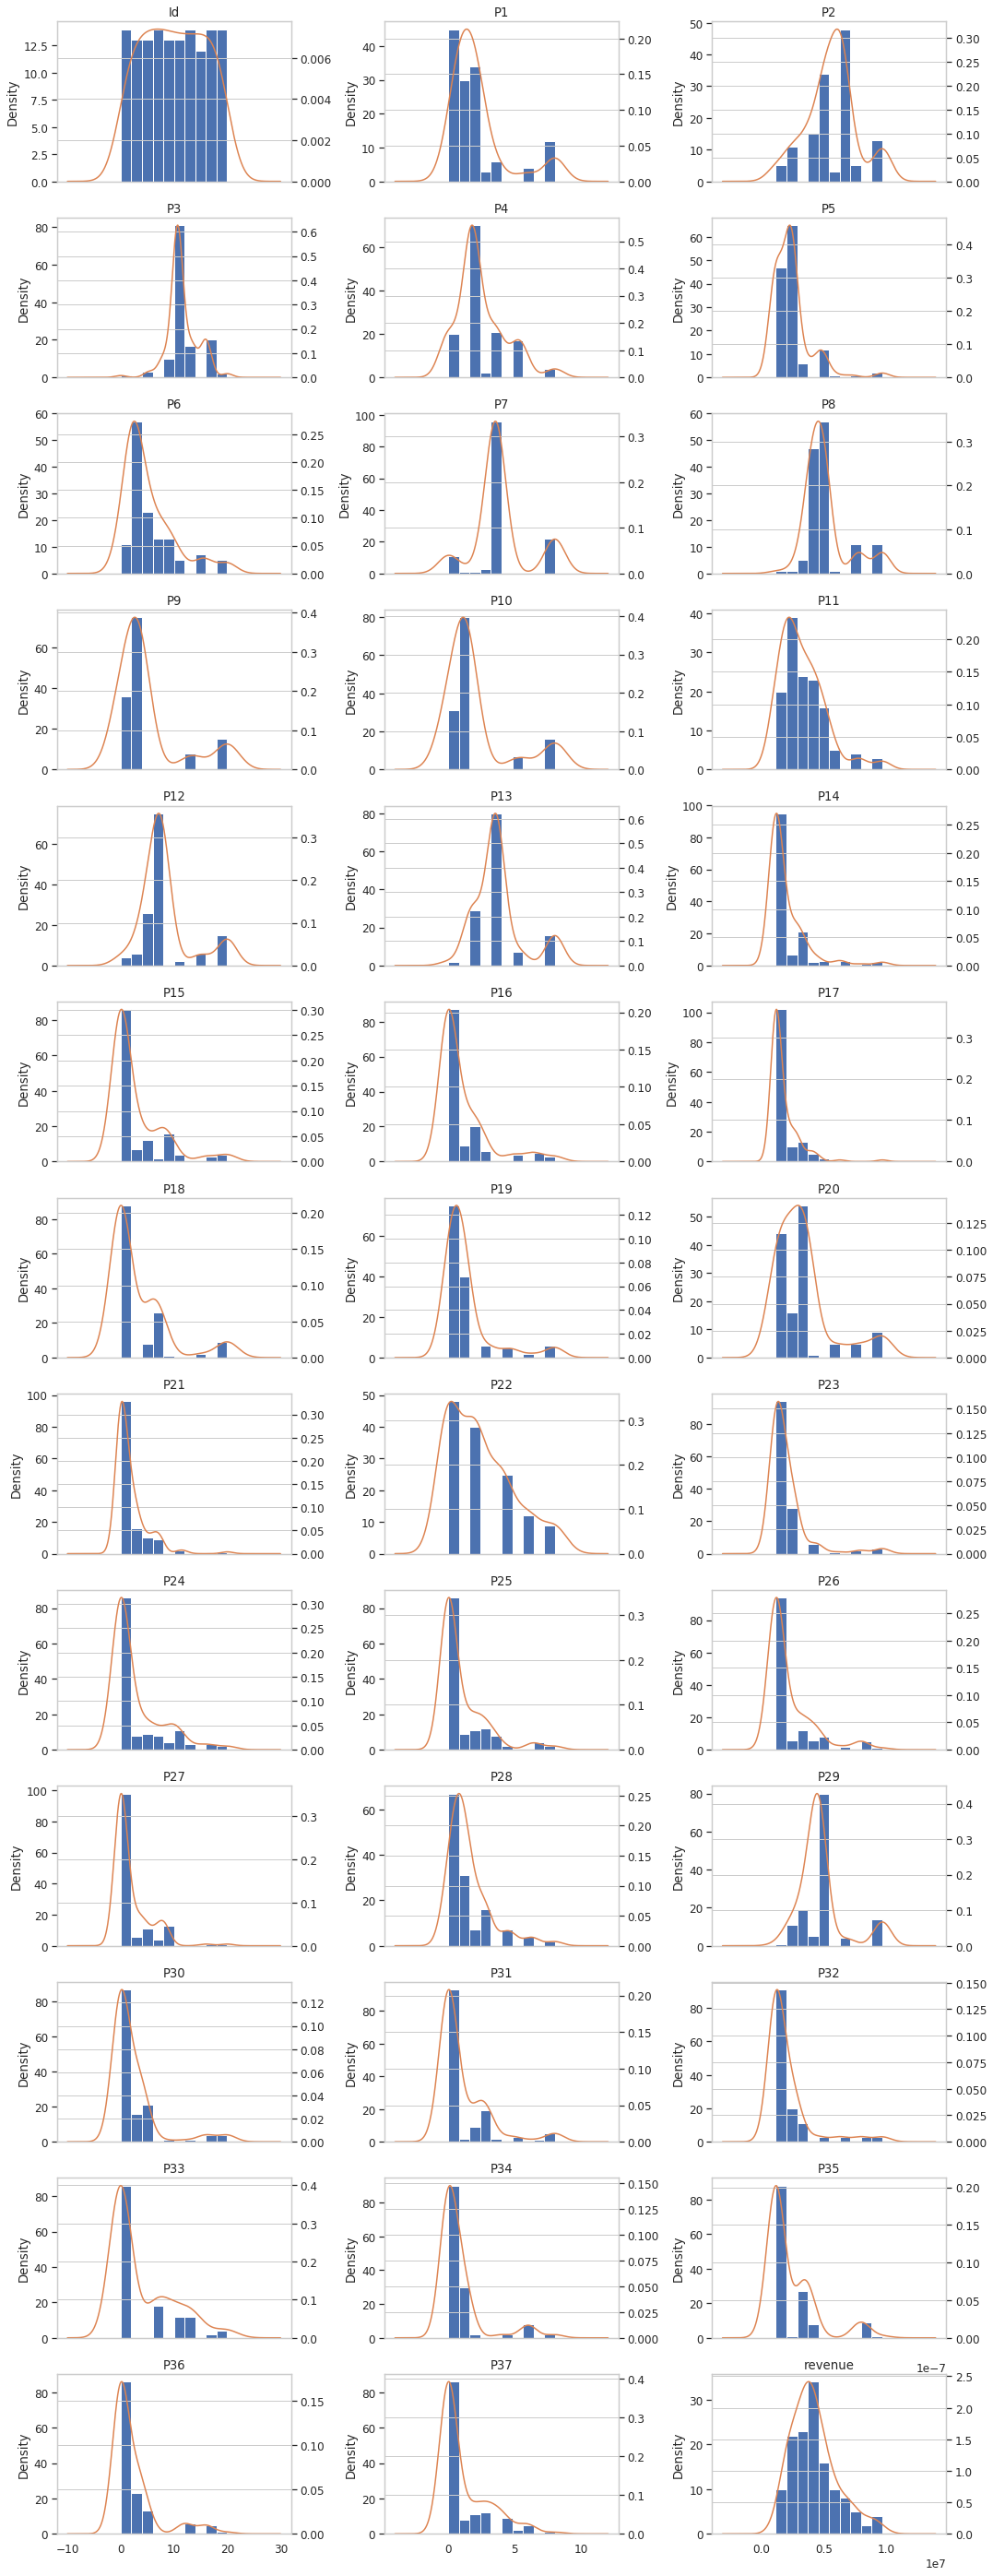

In [18]:
#train[numerical_features].hist(figsize=(30, 35), layout=(12, 4));

k = len(train[numerical_features].columns)
n = 3
m = (k - 1) // n + 1 ## Floor Division (also called Integer Division)
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(train[numerical_features].iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)

fig.tight_layout()

+ as the distributions clearly states that there are clear anamolies in some of the features in hand, these anamonlies has to be studied carefully with an expert in the field, also the distributions above describes certain biases that made that data distribution either not fair or skewed for some reason 
+ For instance if we look at P37 : value zero is more likely to show among the feature values, possibly this is a data entry error or there something important that number zero represents 

In [19]:
train[train['P37']  == 0].shape

(86, 43)

1. ## Analyzing Categorical Variables

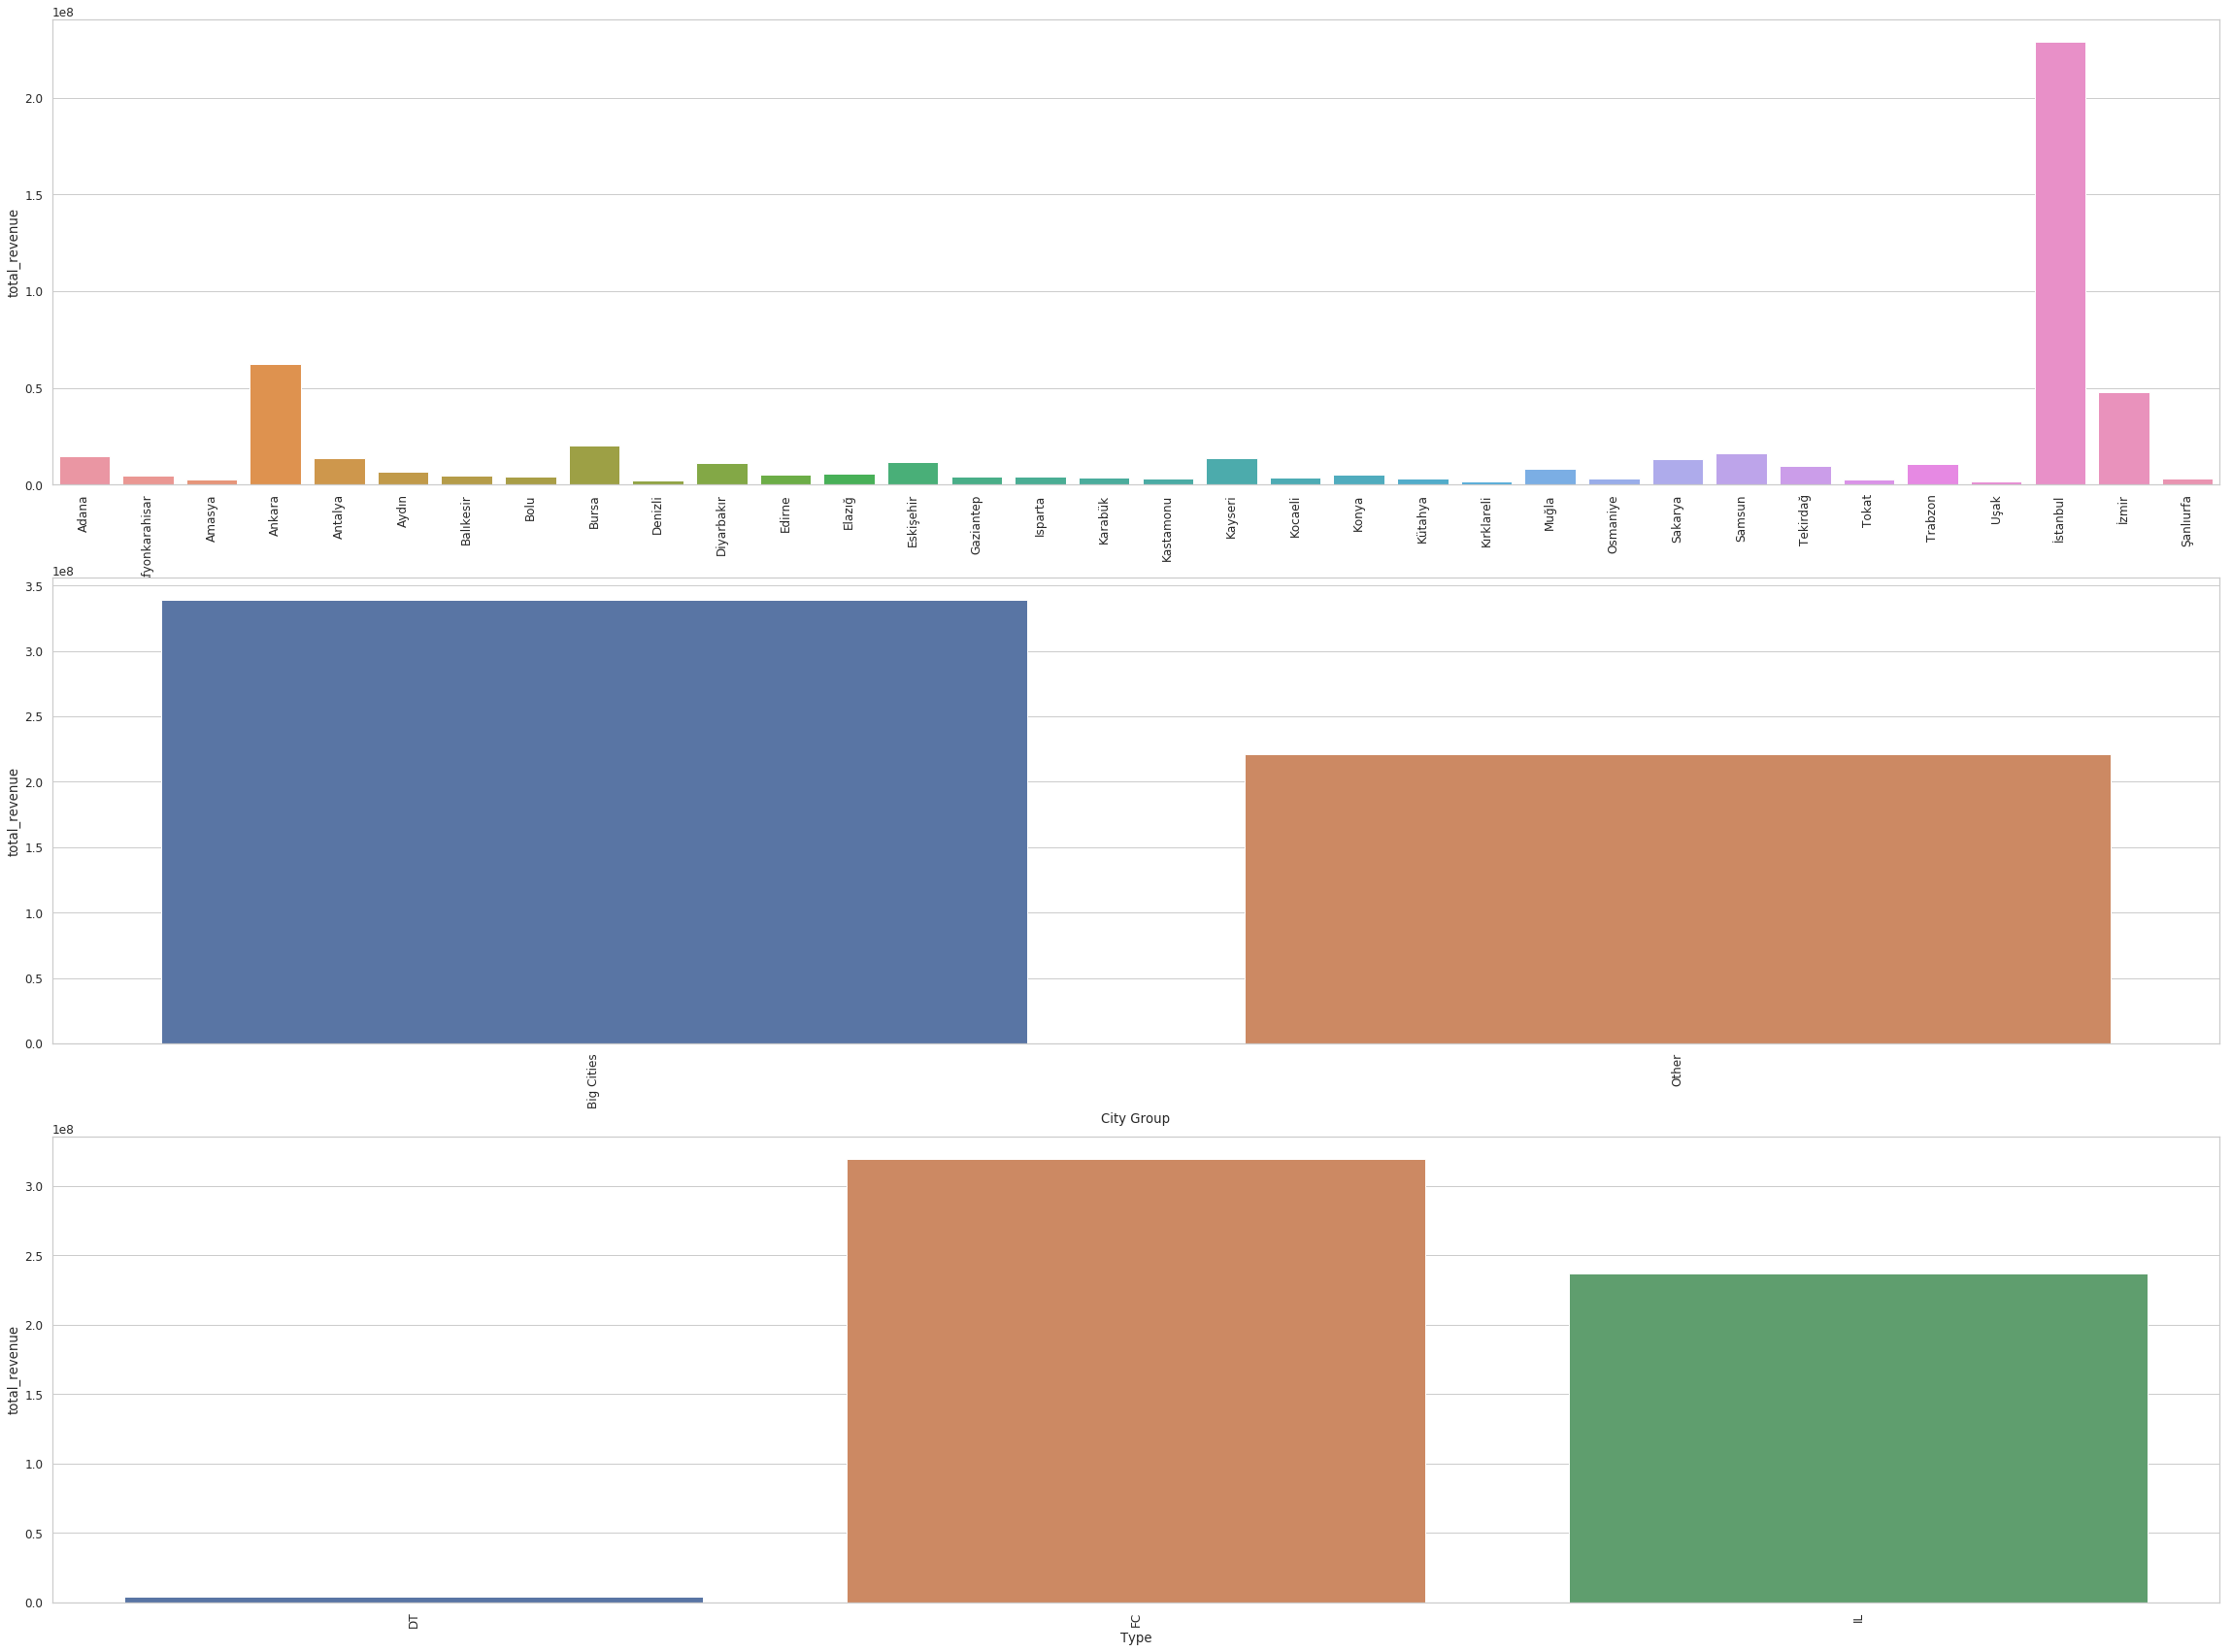

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(40, 30))
for variable, subplot in zip(categorical_features, ax.flatten()):
    df_2 = train[[variable,'revenue']].groupby(variable).revenue.sum().reset_index()
    df_2.columns = [variable,'total_revenue']
    sns.barplot(x=variable, y='total_revenue', data=df_2 , ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

+ As the categorical variables chart shows that Instanbul is making the most revenues compared to other cities, So that Opening a resturant in Instanbul would be a great Idea, the question is when and why .. this questions we will answer in the next segement of our data exploration 
+ It is also clear that big cities are making more revnues than smaller cities yet the gap between them is narrowing thanks to increased number of turists visting them 
+ if you are about to open a resutrant its better be and FC Food court and IL (inline) 

## Analyzing Relationships Between Numerical Variables and the target ['revneue']


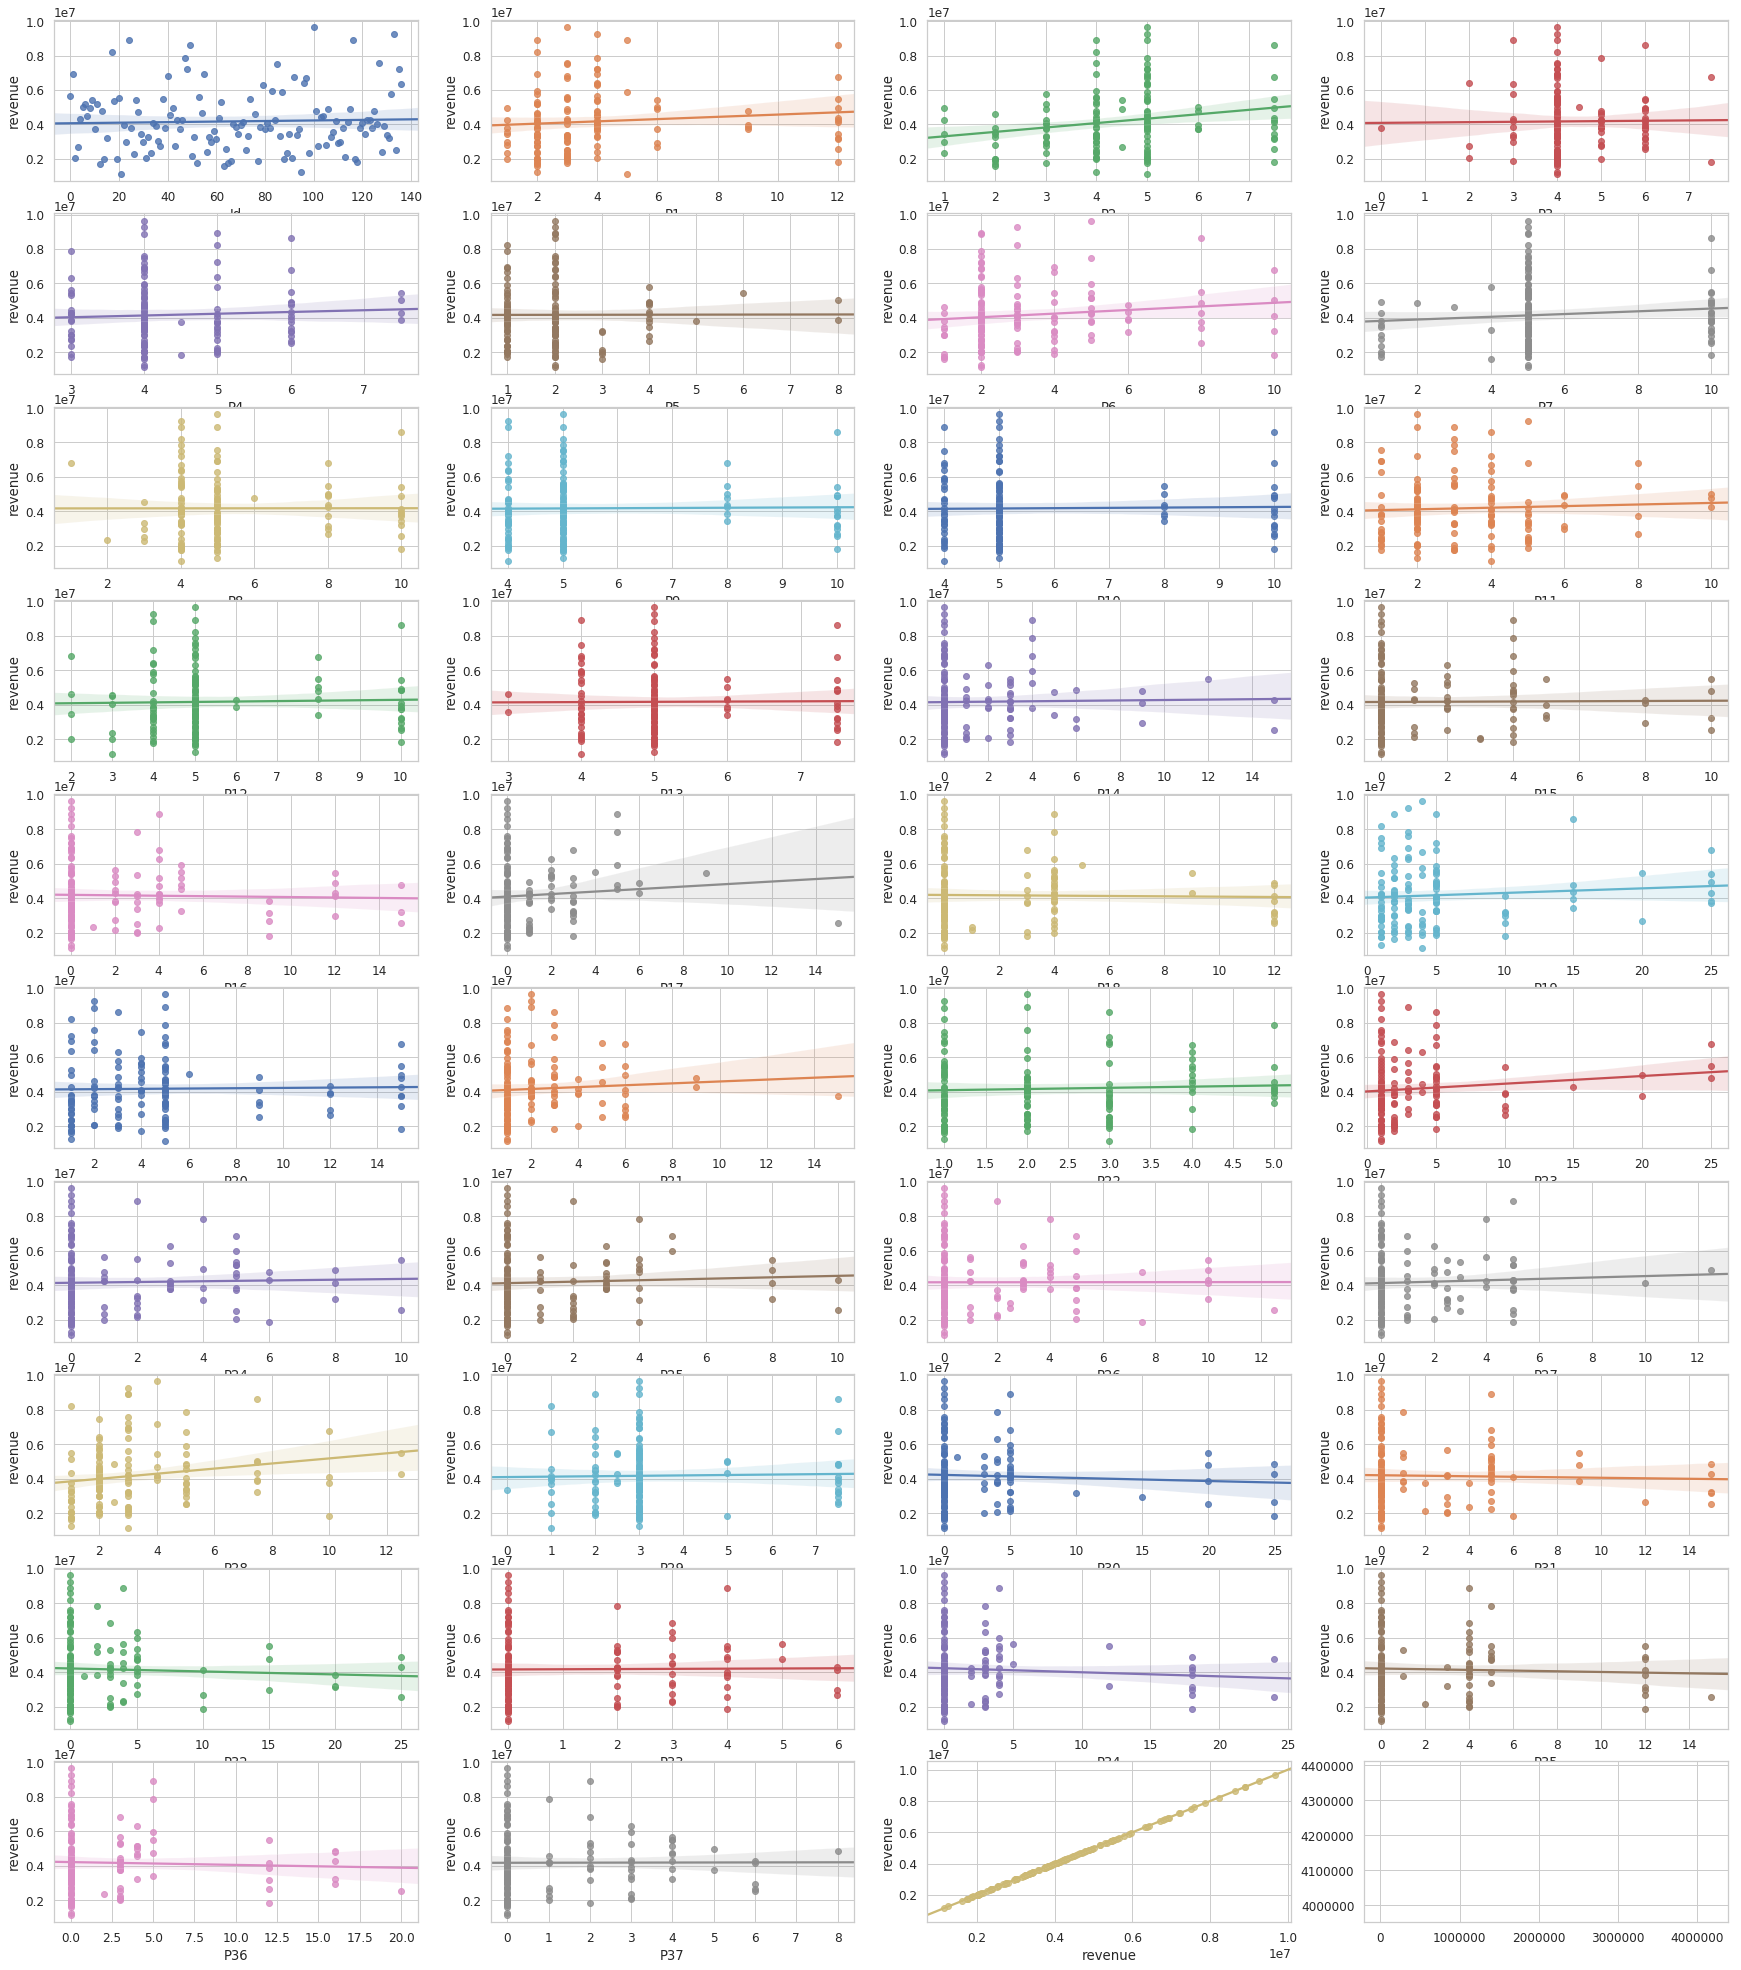

In [21]:
fig, ax = plt.subplots(10, 4, figsize=(30, 35))
for variable, subplot in zip(numerical_features, ax.flatten()):
    sns.regplot(x=train[variable], y=train['revenue'], ax=subplot)

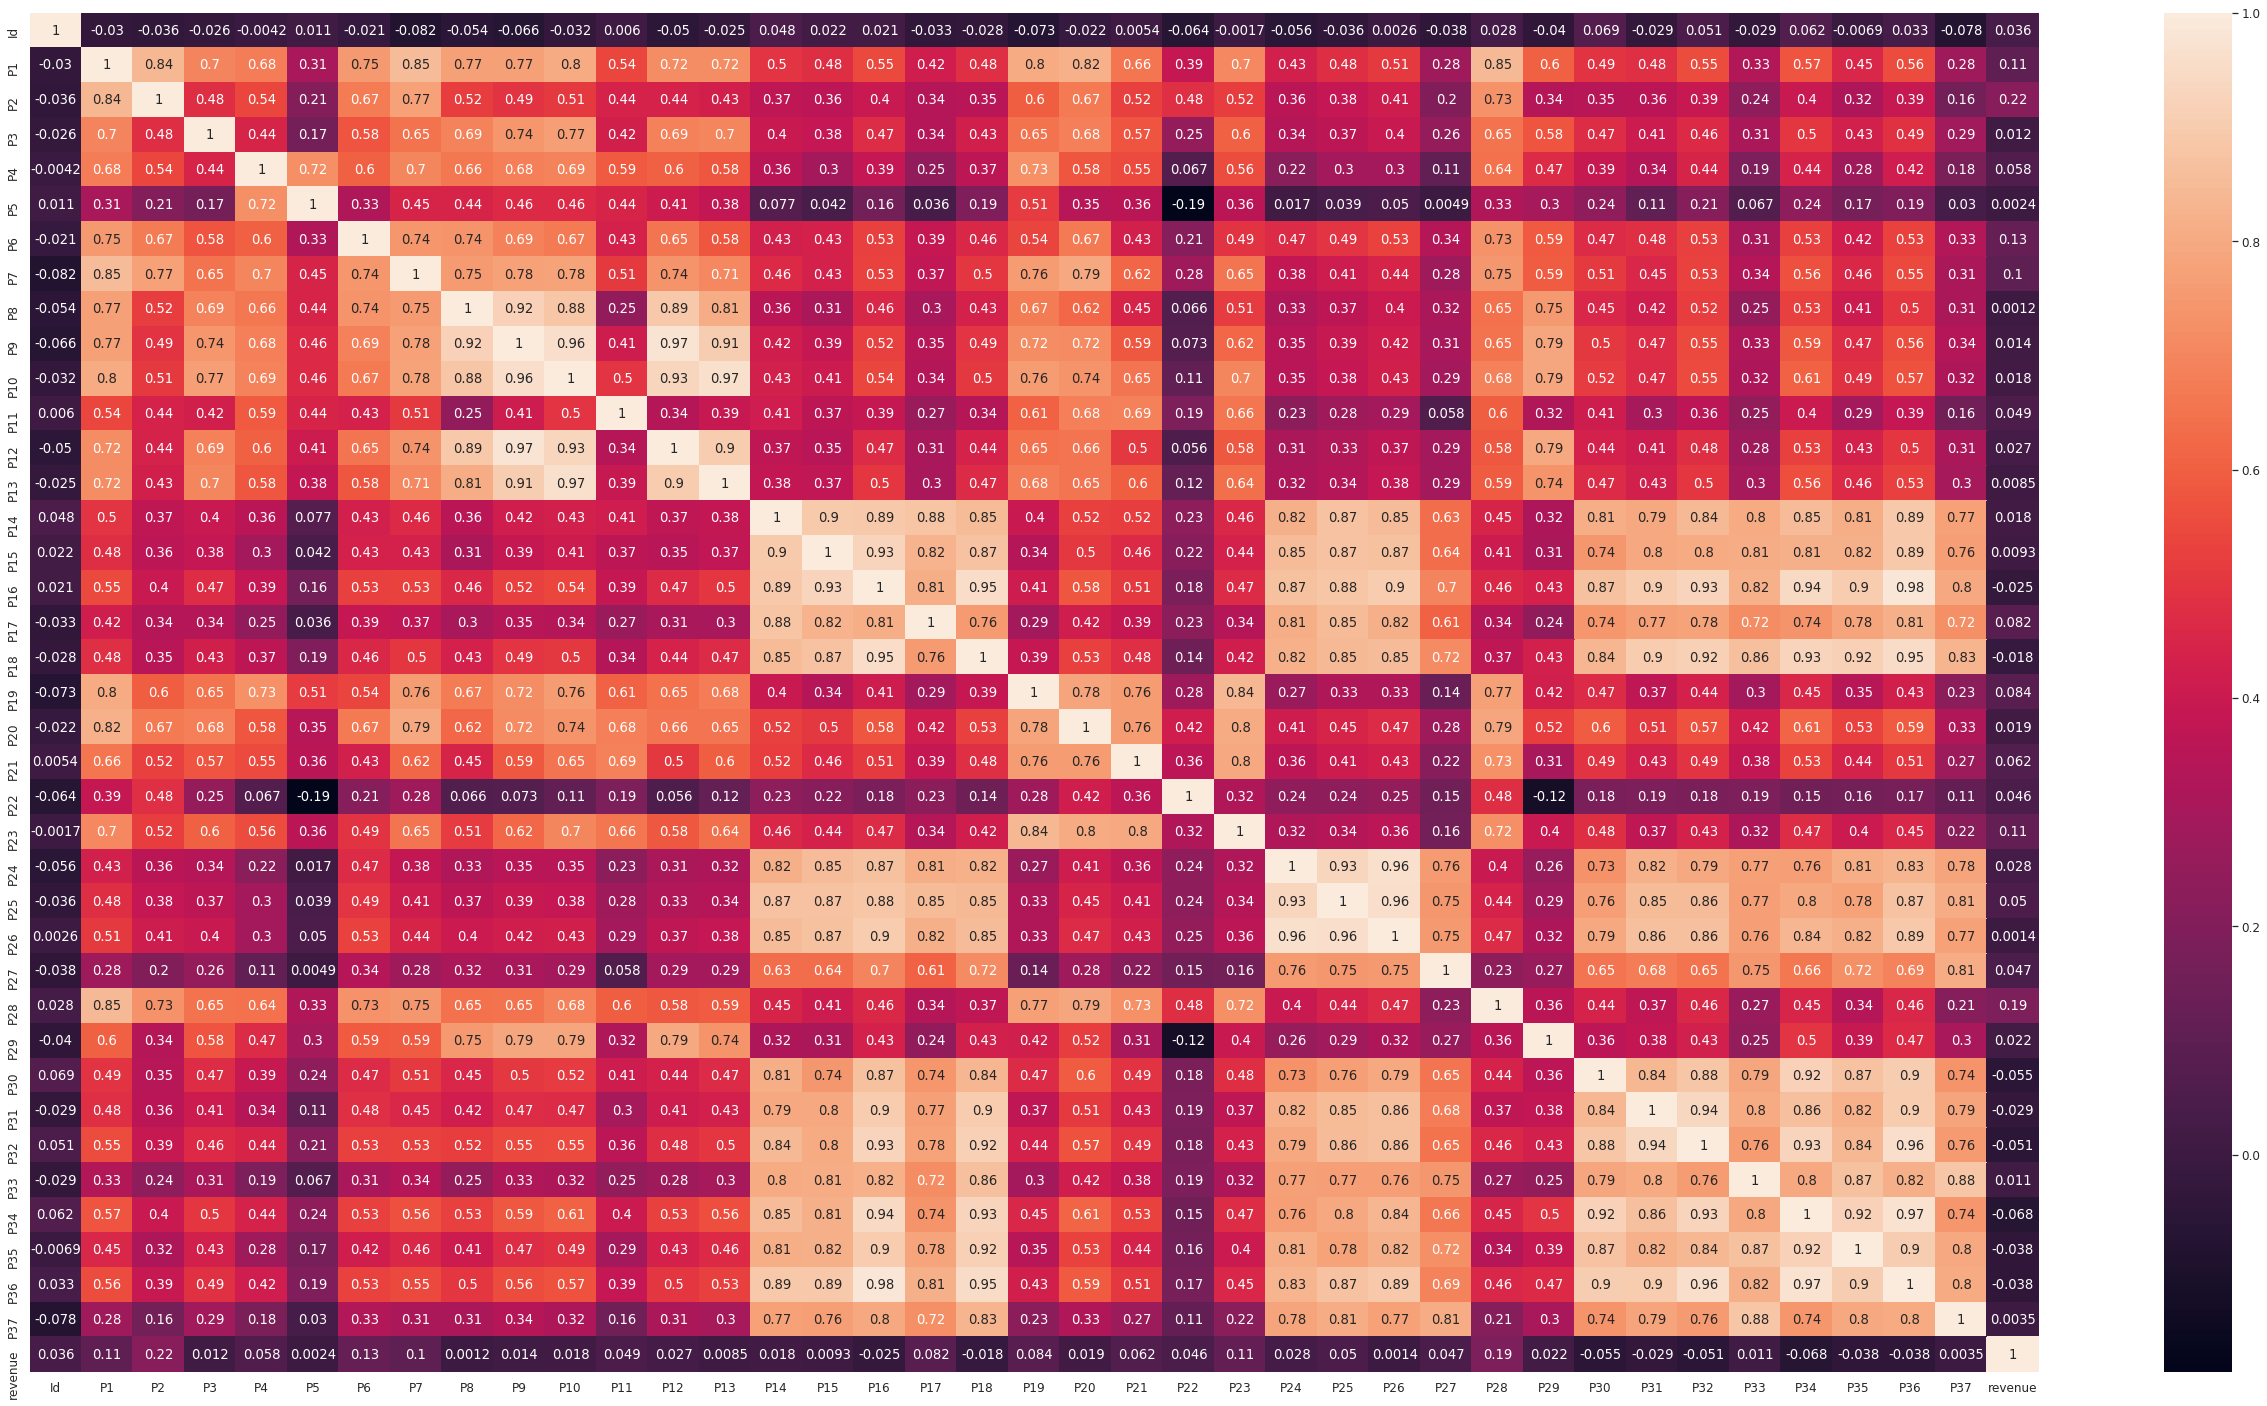

In [22]:
plt.figure(figsize=(45,25))
sns.heatmap(train.corr(),annot=True)

 + As the heatmap and the scatter distribution clearly shows that there is no obvious releation between numerical variables independtly with the target, thought the corrleation can be hidden and we will explore it through machine learning 

## Analyzing Relationships between the Categorical Variables and the target ['revenue']

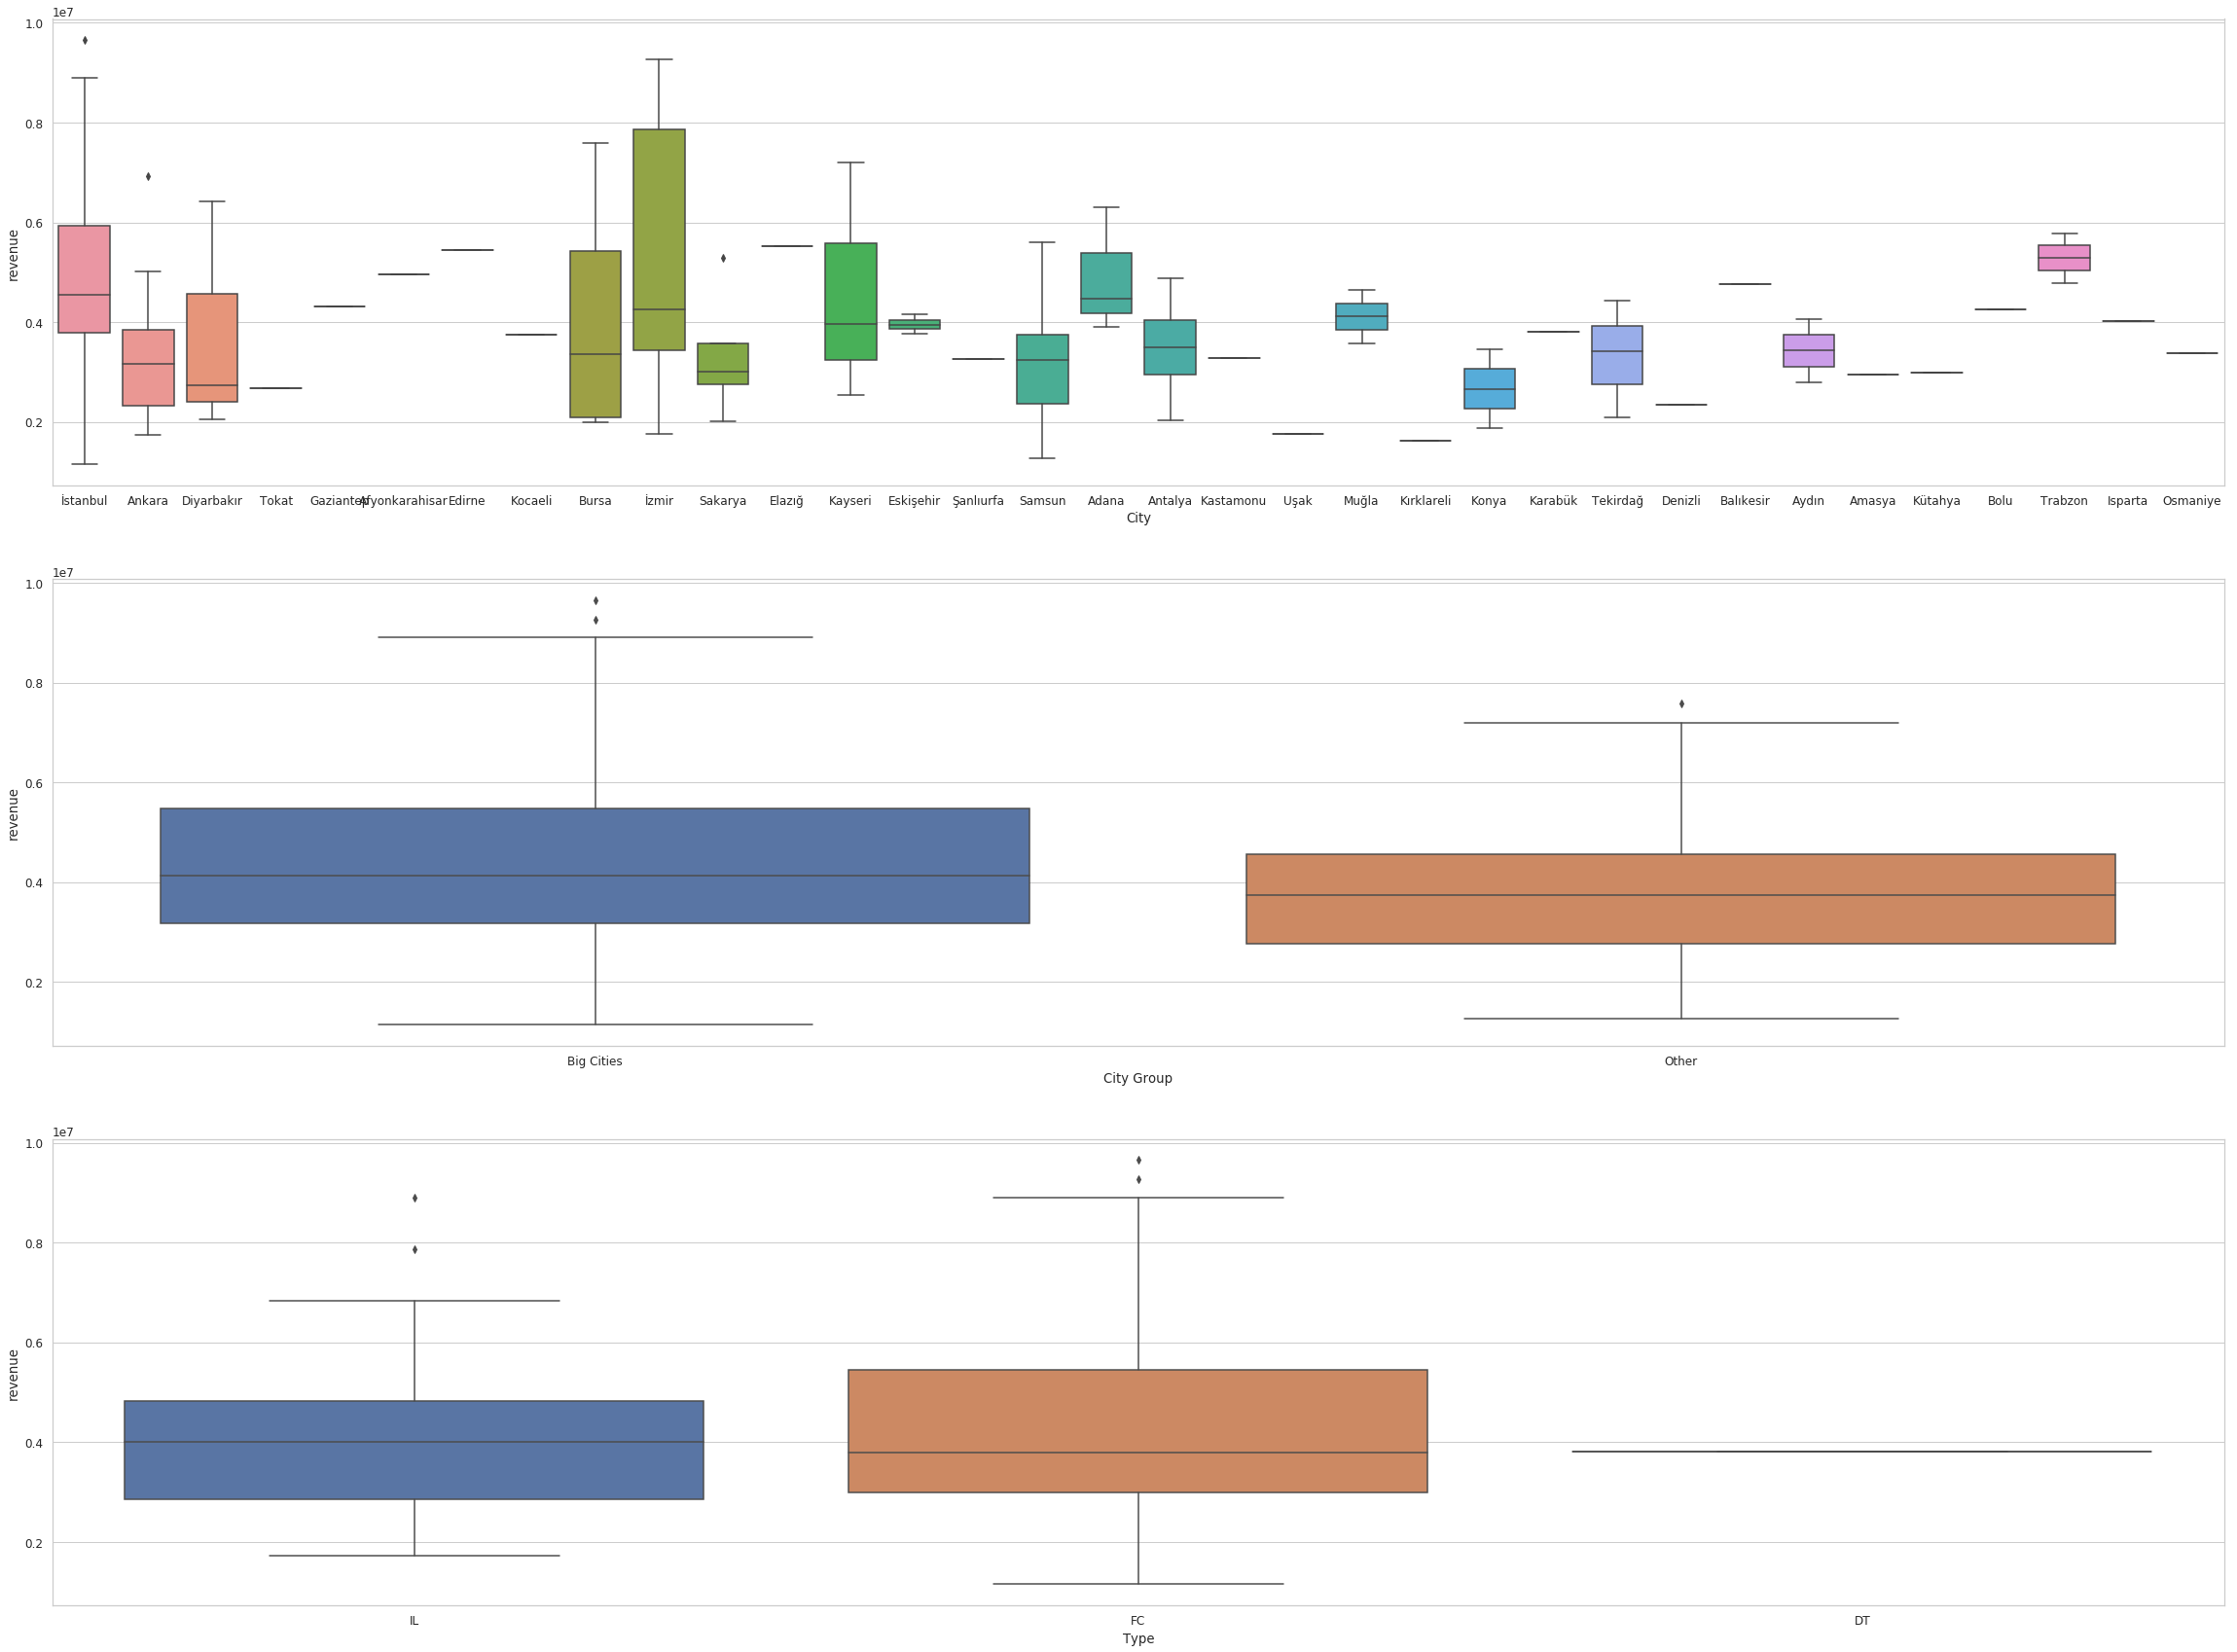

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(40, 30))
for var, subplot in zip(categorical_features, ax.flatten()):
    sns.boxplot(x=var, y='revenue', data=train, ax=subplot)

+ these box plots proves our first conclusion about the best places to invest money and the worst and which types of resturant are more likely to make money than others, in addition, it gives us more insight, as the graph clearly shows that the city of Izmair has a wider range of distributed values in revneue with slighly lower median than istanbul, Ankara could be a good place for opening a resurant and making renveue in time shorther than required if the same resturant is opened in Istanbul 

In [24]:
# Not Applicable 
## STudy relation between P2 and revenue in light of Categorical Variables
#cond_plot = sns.FacetGrid(data=train, col='City', hue='Type', col_wrap=4)
#cond_plot.map(sns.scatterplot, 'P2', 'revenue').add_legend();
#cond_plot = sns.FacetGrid(data=train, col='City Group', hue='Type', col_wrap=4)
#cond_plot.map(sns.scatterplot, 'P2', 'revenue').add_legend();

## Case Study : Analyzing Relationships between the Cities ['İstanbul','İzmir','Ankara','Bursa','Samsun'] feature and the target ['revenue'] with respect to Open_Date and the Type

In [25]:
cats = train["City"].unique()
cats

array(['İstanbul', 'Ankara', 'Diyarbakır', 'Tokat', 'Gaziantep',
       'Afyonkarahisar', 'Edirne', 'Kocaeli', 'Bursa', 'İzmir', 'Sakarya',
       'Elazığ', 'Kayseri', 'Eskişehir', 'Şanlıurfa', 'Samsun', 'Adana',
       'Antalya', 'Kastamonu', 'Uşak', 'Muğla', 'Kırklareli', 'Konya',
       'Karabük', 'Tekirdağ', 'Denizli', 'Balıkesir', 'Aydın', 'Amasya',
       'Kütahya', 'Bolu', 'Trabzon', 'Isparta', 'Osmaniye'], dtype=object)

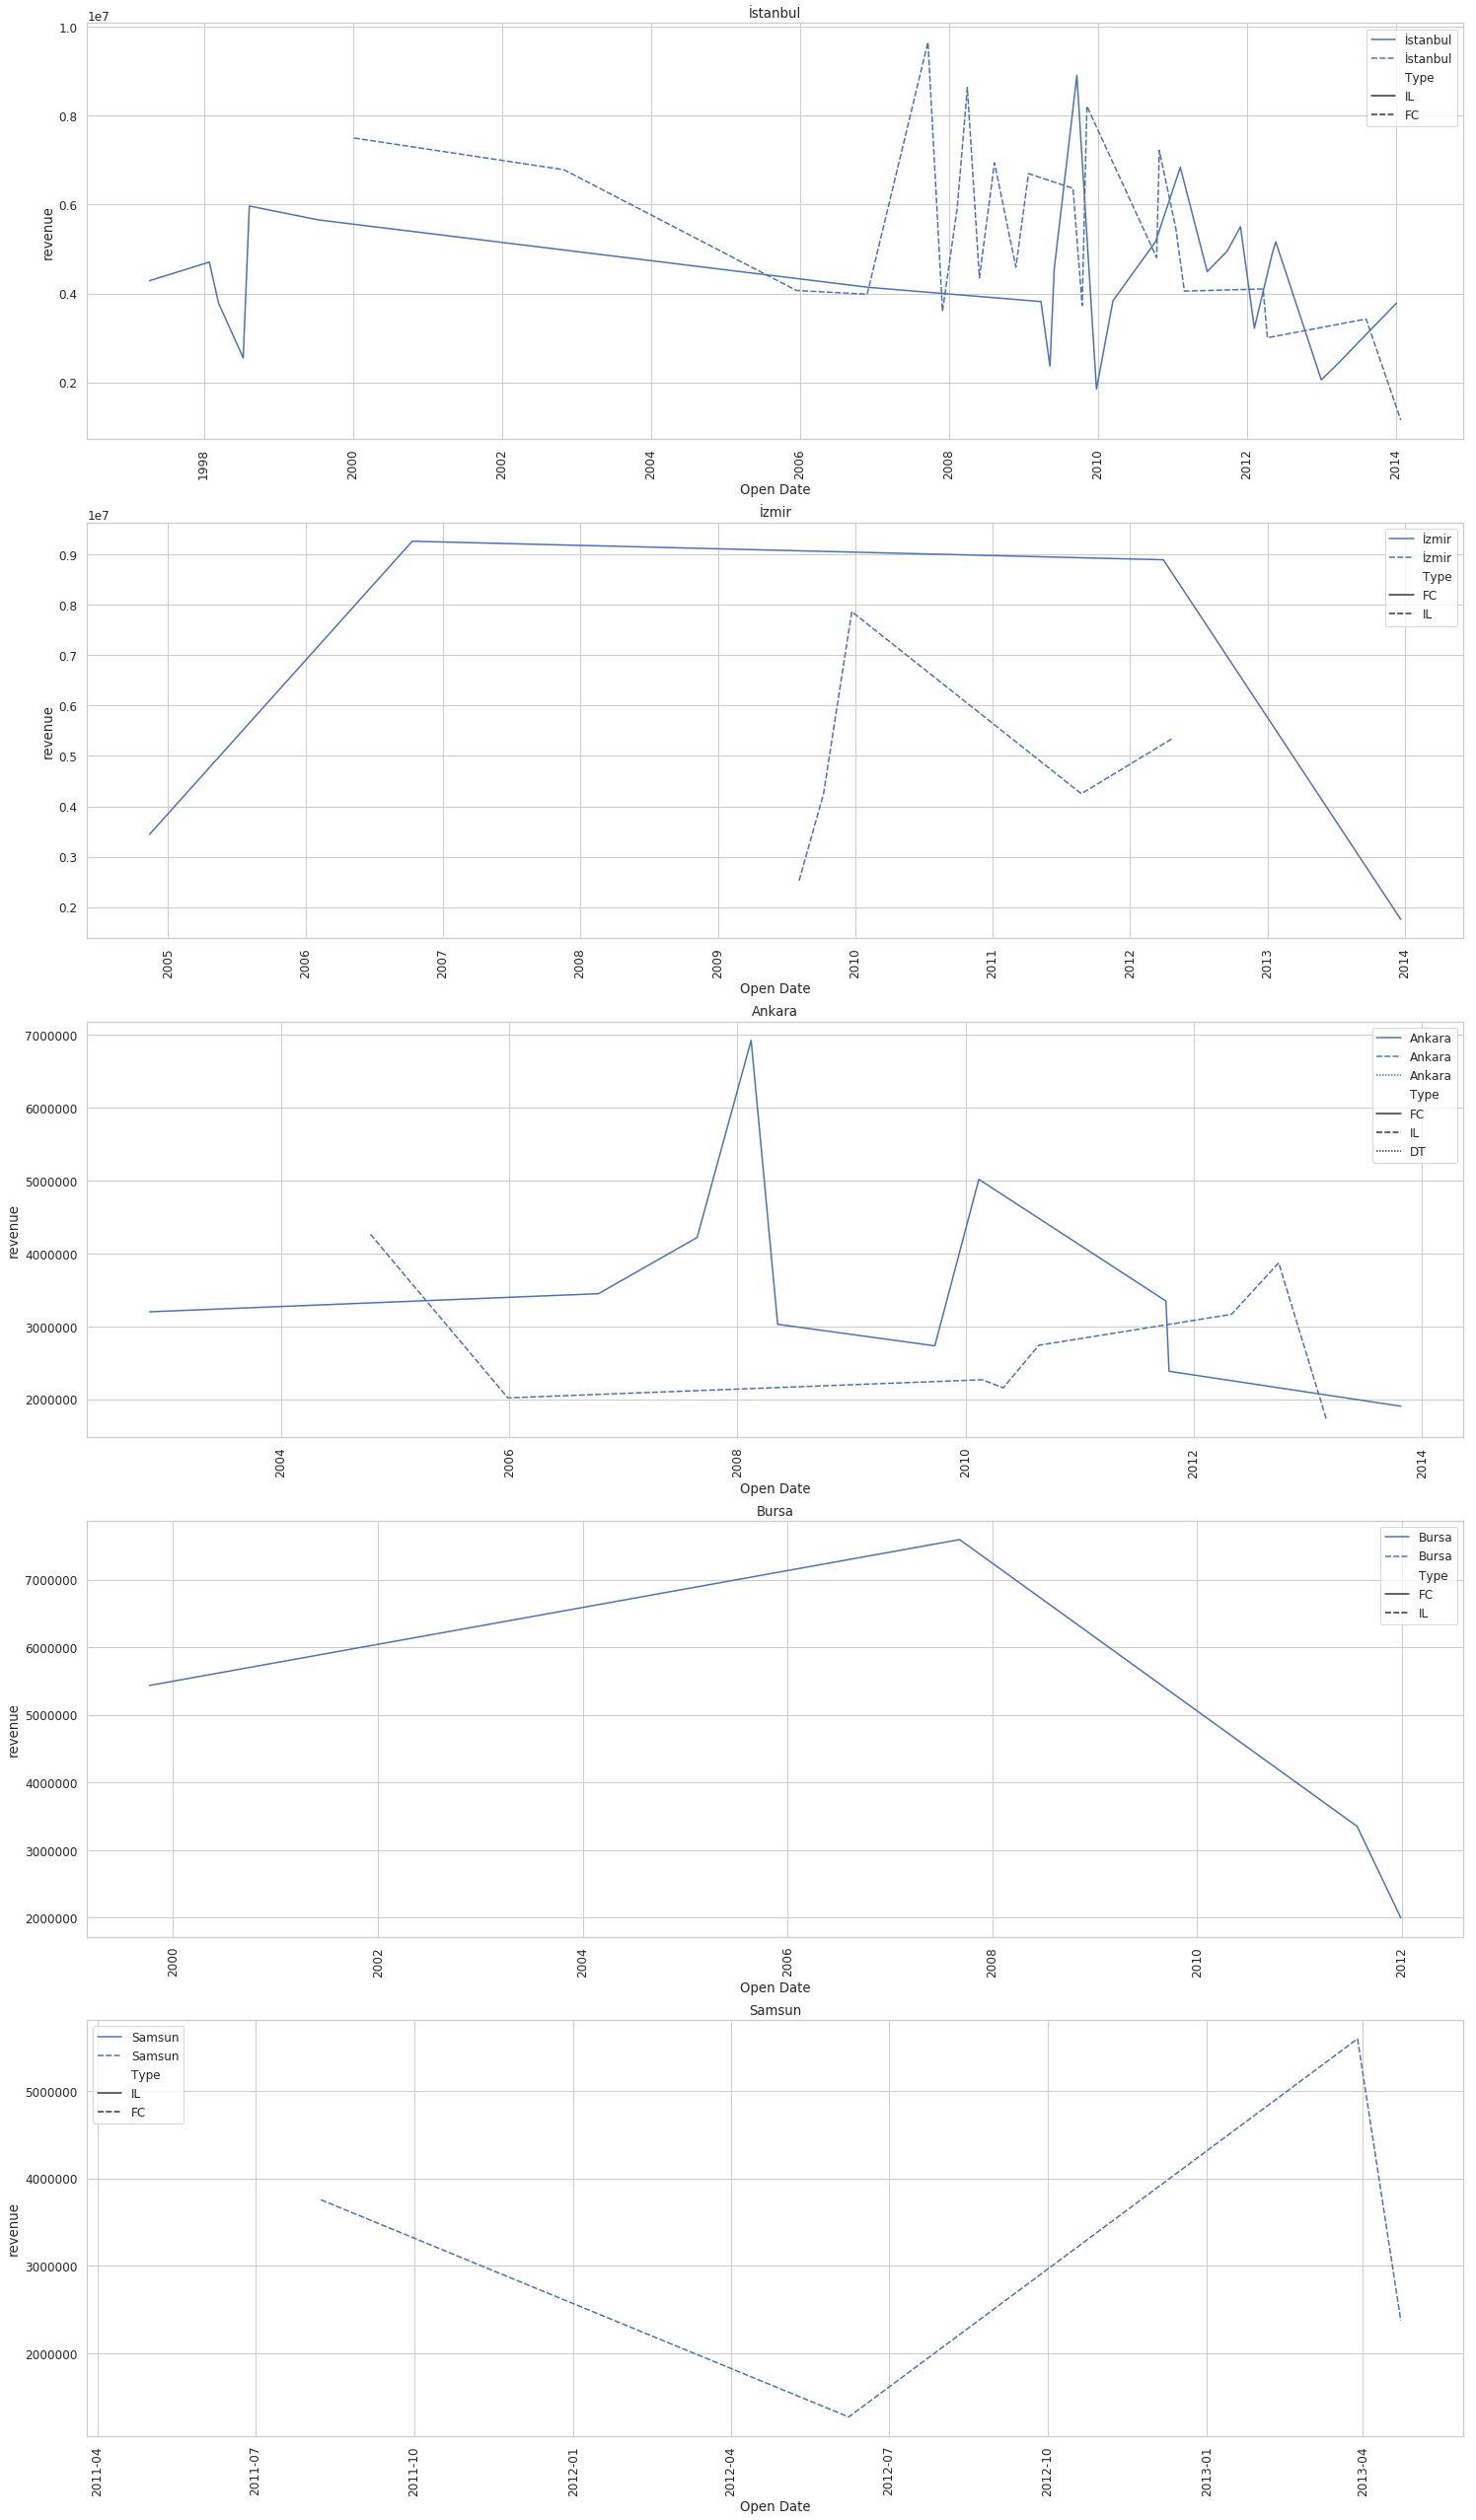

In [26]:
tem = train.copy()
#cats = train["City"].unique().tolist() 
#fig, ax = plt.subplots(34, 1, figsize=(25, 400))
cats = ['İstanbul','İzmir','Ankara','Bursa','Samsun']
fig, ax = plt.subplots(5, 1, figsize=(25, 45))
for variable, subplot in zip(cats, ax.flatten()):
    #x = tem.where(train["City"]==variable, inplace = False)
    x = tem[train["City"]==variable]
    x = x.sort_values(by=['Open Date'])
    if len(x) <= 4:        
        g = sns.barplot(x="Open Date", y="revenue",hue="Type", data=x, ax=subplot)
        g.title.set_text(variable)
    else:
        g = sns.lineplot(x="Open Date", y="revenue", style = "Type",label=variable, linestyle="-", data=x, ax=subplot)
        g.title.set_text(variable)
        for label in subplot.get_xticklabels():
            label.set_rotation(90)

+ The graphs clearly shows that the best option is to open an inline resturant in Istanbul as all the renuvues are plummeting in Turkey since 2006 - 2008, yet there is hope that inline resutrants will start making profits as their renvues grow up slighly in 2014 

## Answers to the above questions 

+ Which is the best city to Open a resutrant ?  # Istanbu

+ What is the best time in year to open a resutrant in that city ?  # first quarter of the year

+ What is the best type of resturant to be opened ? #IL inline 



## 3 - Data preparation
In this phase we are going to prepare the data to be machine learned, we will deal with categircal variables and numberical veriables in addition to the dates  

In [27]:
from sklearn import preprocessing
##from sklearn.model_selection import train_test_split

In [28]:
## as can be seen that test has more rows than the training dataset 
## as the viuslization clearly express no clear relation in the train
num_train = train.shape[0]
num_test = test.shape[0]
print(num_train, num_test)

# For feature engineering, combine train and test data
data = pd.concat((train.loc[:, "Id" : "P37"],
                  test.loc[:, "Id" : "P37"]), ignore_index=True)

134 100000


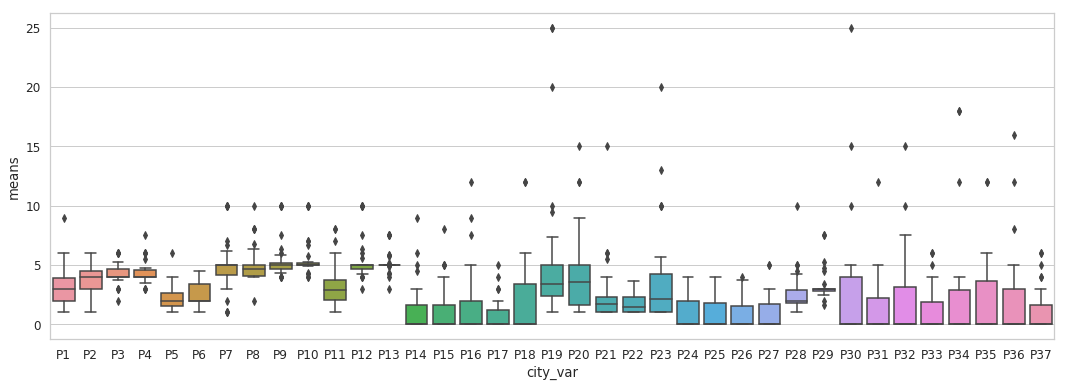

In [29]:
# Plotting mean of P-variables over each city helps us see which P-variables are highly related to City
# since we are given that one class of P-variables is geographical attributes.
distinct_cities = train.loc[:, "City"].unique()

# Get the mean of each p-variable for each city
means = []
for col in train.columns[5:42]:
    temp = []
    for city in distinct_cities:
        temp.append(train.loc[train.City == city, col].mean())     
    means.append(temp)
    
# Construct data frame for plotting
city_pvars = pd.DataFrame(columns=["city_var", "means"])
for i in range(37):
    for j in range(len(distinct_cities)):
        city_pvars.loc[i+37*j] = ["P"+str(i+1), means[i][j]]
#print(city_pvars)        
# Plot boxplot
plt.rcParams['figure.figsize'] = (18.0, 6.0)
sns.boxplot(x="city_var", y="means", data=city_pvars)

In [30]:
from sklearn import cluster
# K Means treatment for city (mentioned in the paper)
def adjust_cities(data, train, k):
    
    # As found by box plot of each city's mean over each p-var
    relevant_pvars =  ["P1", "P2", "P11", "P19", "P20", "P23", "P30"]
    train = train.loc[:, relevant_pvars]
    
    # Optimal k is 20 as found by DB-Index plot    
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(train)
    
    # Get the cluster centers and classify city of each data instance to one of the centers
    data['City Cluster'] = kmeans.predict(data.loc[:, relevant_pvars])
    del data["City"]
    
    return data

def one_hot_ecoding(data,col,pref):
    # One hot encode City Group
    data = data.join(pd.get_dummies(data[col], prefix=pref))
    # Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
    # And drop the original columns.
    data = data.drop([col], axis=1)
    return data 

In [31]:
# Convert unknown cities in test data to clusters based on known cities using KMeans
data = adjust_cities(data, train, 20)
#data = data.drop(['City'], axis=1)
data = one_hot_ecoding(data,'City Group',"CG")
data = one_hot_ecoding(data,'Type',"T")

In [32]:
data.dtypes

Id                        int64
Open Date        datetime64[ns]
P1                        int64
P2                      float64
P3                      float64
P4                      float64
P5                        int64
P6                        int64
P7                        int64
P8                        int64
P9                        int64
P10                       int64
P11                       int64
P12                       int64
P13                     float64
P14                       int64
P15                       int64
P16                       int64
P17                       int64
P18                       int64
P19                       int64
P20                       int64
P21                       int64
P22                       int64
P23                       int64
P24                       int64
P25                       int64
P26                     float64
P27                     float64
P28                     float64
P29                     float64
P30     

In [33]:
# Split into train and test datasets
train_processed = data[:num_train]
test_processed = data[num_train:]
# check the shapes 
print("Train :",train.shape)
print("Test:",test.shape)

Train : (134, 43)
Test: (100000, 42)


In [34]:
#sav_train = pd.DataFrame()
#sav_train = train["revenue"].copy()

In [35]:
train["revenue"] = [np.log(num) for num in train["revenue"]]
len(train["revenue"])

134

In [36]:
train_processed["revenue"] = train["revenue"].values ## if you do not put this values , then you are in complete danger
#train_processed["Id"] = train["Id"]
#test_processed["Id"] = test["Id"]
train = train_processed
test = test_processed

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
# check the shapes 
print("Train :",train.shape)
print("Test:",test.shape)

Train : (134, 47)
Test: (100000, 46)


In [38]:
import time
from datetime import datetime as dt

## prepartion function 
def prepare_data_frame(dataframe, target):
    df = dataframe.copy()
    ## Splittin the date column into three columns 
    df['Open Date Year']  = df['Open Date'].dt.year
    df['Open Date Month']  = df['Open Date'].dt.month
    df['Open Date Day']  = df['Open Date'].dt.day
    ##---------------------------------------
    ## feature Engineering Begining 
    ##--------------------------------------
    ## feature Engineering a diff column 
    ## since when this resturant was opened
    all_diff = []
    for date in df["Open Date"]:
        diff = dt.now() - date
        all_diff.append(int(diff.days/1000))
    df['Days_from_open'] = pd.Series(all_diff)
    ##---------------------------------------
    ## feature Engineering End 
    ##--------------------------------------
    # drop Open Date column s
    df = df.drop(['Open Date'], axis=1)
    # drop target column s
    if target in df.columns:
        tar = df[target]
        df = df.drop([target], axis=1)
    else:
        tar = None
    # get numberical variables 
    num_vars = df.select_dtypes([np.number]).columns.tolist()
    # encoding categrical variables 
    #categorical variables already encoded in one hot encoding
    # get cat variables 
    cat_vars = df.select_dtypes(include='object').columns.tolist()
    df[cat_vars] = df[cat_vars].apply(preprocessing.LabelEncoder().fit_transform)
    #df.loc[:, "P1" :"P37"] = preprocessing.MinMaxScaler().fit_transform(df.loc[:, "P1" : "P37"])
    return (df,tar)

In [39]:
X_train,y_train = prepare_data_frame(train,'revenue')
X_test,y_test = prepare_data_frame(test,'revenue') ## there is no revnue in test\

ValueError: Must have equal len keys and value when setting with an iterable

In [40]:
X_train.shape

NameError: name 'X_train' is not defined

In [41]:
y_train.shape

NameError: name 'y_train' is not defined

In [42]:
X_test.shape

NameError: name 'X_test' is not defined

## 4 - Data Modeling
Defines a machine learning algorithm to regress the relationship between all features and the target  

In [43]:
#! pip install tensorflow==2.0.0-beta1

In [44]:
#install tensorflow if not installed
## import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRegressor
#from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [45]:
def get_reg_mse(model,in_parameters):
    # Define the model
    my_model_1 = model # Your code here
    clf = GridSearchCV(my_model_1, in_parameters, cv=2, scoring='neg_mean_squared_error')
    # Fit the model
    clf.fit(X_train, y_train) # Your code here
    #predictions_1 = clf.predict(X_valid) # Your code here
    #mae_1 = mean_absolute_error(y_true=y_valid, y_pred=predictions_1) # Your code here
    print('best_params_',clf.best_params_)
    mae_1 = clf.best_score_ * -1
    return mae_1

In [46]:
def baseline_model():
    dim = len(X_train.columns.tolist())
    if not isinstance(dim, int):
        return 0
    model = tf.keras.Sequential([
        layers.Dense(dim, input_dim=dim, kernel_initializer='normal', activation='relu'),
        layers.Dense(int(round(dim/2)), kernel_initializer='normal', activation='relu'), ## 
        layers.Dense(int(round(dim/4)), kernel_initializer='normal', activation='relu'), ## 
        layers.Dense(int(round(dim/8)), kernel_initializer='normal', activation='relu'), ## 
        layers.Dense(1, kernel_initializer='normal')
    ])
    #model.compile(loss='mean_squared_error', optimizer='adam')111
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    return model

In [47]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

def get_reg_keras_mse(in_parameters):
    # Define the model
    # evaluate model with standardized dataset
    my_model_1 = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=baseline_model, verbose=1)
    reg = GridSearchCV(my_model_1, in_parameters, cv=2, scoring='neg_mean_squared_error')
    X_ktrain = StandardScaler().fit_transform(X_train.values)  
    arr = sav_train['rev_save'].values 
    y_ktrain = StandardScaler().fit_transform(arr[:, np.newaxis])
    
    reg.fit(X_ktrain, y_train.values) # Your code here
    # Fit the model
    print('best_params_',reg.best_params_)
    mse_1 = reg.best_score_ * -1
    return mse_1

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32, target_name='target'):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target_name)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

def input_fn(features, labels, training=True, batch_size=32):
    """An input function for training or evaluating"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        #dataset = dataset.shuffle(1000).repeat()
        dataset = dataset.shuffle(buffer_size=len(features))
    
    return dataset.batch(batch_size)

* ## XGBoost Mean S Error: 0.25096676125467654

In [48]:
#Parameters for tuning model 
#n_esitmators = list(range(100, 1001, 100))
#learning_rates = [x / 100 for x in range(5, 101, 5)]
#parameters = {'n_esitmators':n_esitmators, 'learning_rates':learning_rates}
#mse_1 = get_reg_mse(XGBRegressor(),parameters)
# Uncomment to print MAE
#print("Mean Squared Error:" , mse_1)

## Support Vector Regression.0.229699386793816

In [49]:
#c = list(np.arange(1, 10, 0.1))
#cache_size=list(range(100, 1001, 100))
#parameters = {'kernel':('linear', 'rbf'), 'C':c,'cache_size':cache_size}
#mse_1 = get_reg_mse(SVR(gamma='scale'),parameters)
# Uncomment to print MAE
#print("Mean Squared Error:" , mse_1)

1. ## RandomForestRegressor : 0.21991174394344817

In [50]:
#n_estimators=list(range(100, 501, 100))
#max_depth = list(range(1, 5, 1))
#parameters = {'n_estimators':n_estimators,'max_depth':max_depth}
#mse_1 = get_reg_mse(RandomForestRegressor(random_state=400),parameters)
# Uncomment to print MAE
#print("Mean Squared Error:" , mse_1)

## LassoCV regressor :  0.23536168489619116

In [51]:
#random_state=list(range(0, 100, 1))
#parameters = {'random_state':random_state}
#mse_1 = get_reg_mse(LassoCV(cv=2),parameters)
# Uncomment to print MAE
#print("Mean Squared Error:" , mse_1)

## KerasRegressor (Neural Network)

In [52]:
#seed = 1
#epochs=list(range(100, 101, 100))
#batch_size = [1,5]
#parameters = {'epochs':epochs,'batch_size':batch_size}
#mse_1 = get_reg_keras_mse(parameters)
# Uncomment to print MAE
#print("Mean Squared Error:" , mse_1)

## 4 - Data Test Prediction
Lets make predictions 

In [53]:
samp = pd.read_csv('/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv')
samp.head()

,Id,Prediction
0,0,4453532.6
1,1,4453532.6
2,2,4453532.6
3,3,4453532.6
4,4,4453532.6


In [54]:
# other regressors
#reg = RandomForestRegressor(random_state = 400, max_depth = 1, n_estimators = 500)
#reg.fit(X_train,y_train)
#print (reg)

In [55]:
## keras regressor
#reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=baseline_model,batch_size=5,epochs=100, verbose=1)
#X_ktrain = StandardScaler().fit_transform(X_train.values)  
#arr = sav_train['rev_save'].values 
#y_ktrain = StandardScaler().fit_transform(arr[:, np.newaxis])
#reg.fit(X_ktrain,y_ktrain)
#طprint (reg)

In [56]:
## deal with null values in test dataset
#cols3 = X_test.columns[X_test.isna().any()].tolist()
#print(cols3)
#X_test['Days_from_open'] = X_test['Days_from_open'].fillna(int(round(X_test['Days_from_open'].mean())))

In [57]:
#Predict 
#id_vals = X_test['Id'].values
#output = reg.predict(X_test) #data=X_test for other Regressors
#output = np.exp(output)
#final_df = pd.DataFrame()
#final_df["Id"] = id_vals
#final_df["Prediction"] = output.round(1)
#final_df.to_csv("Output_Keras.csv", index=False)
#print('Check for Na : ',final_df.isna().sum())
#print('Check for Inf : ',np.isfinite(final_df).sum())

In [58]:
final_df.head()

NameError: name 'final_df' is not defined